In [1]:
!pip install -U quandl numpy pandas requests pandas-datareader DateTime yahoo_fin seaborn scipy numpy-financial

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import json
import requests
from yahoo_fin import stock_info as si
from datetime import datetime, timedelta

# Utils

In [3]:
def get_us_treasuries_yield():
    url = "https://quote.cnbc.com/quote-html-webservice/quote.htm"
    params = {
        "noform": "1",
        "partnerId": "2",
        "fund": "1",
        "exthrs": "0",
        "output": "json",
        "symbolType": "issue",
        "symbols": "5093148|5093149|5093150|15183113|5093151|5093158|5093159|19892965|5093160|135058359|5093168",
        "requestMethod": "extended",
    }
    data = requests.get(url, params=params).json()
    result = {
        "symbol": [],
        "last": [],
    }
    for q in data["ExtendedQuoteResult"]["ExtendedQuote"]:
        result["symbol"].append(q["QuickQuote"]["symbol"])
        result["last"].append(q["QuickQuote"]["last"])
    return pd.DataFrame.from_dict(result)


def weights_sampler(samples, sum_to, range_list):
    assert range_list[0] < range_list[1], "Range should be a list, the first element of which is smaller than the second"
    arr = np.random.uniform(low=range_list[0], high=range_list[1], size=samples)
    sum_arr = sum(arr)

    difference = sum(arr) - sum_to
    
    while abs(difference) > 1e-5:
        if difference < 0:
                for idx in np.random.choice(len(arr), int(abs(difference*1e5))):
                    if arr[idx] < range_list[1]:
                        arr[idx] += 1e-5

        if difference > 0:
                for idx in np.random.choice(len(arr), int(difference*1e5)):
                    if arr[idx] > range_list[0]:
                        arr[idx] -= 1e-5
        difference = sum(arr) - sum_to
    return arr

# Inputs

**tickers** - list of tickers in your portfolio

**historical_data_years** - number of years to fetch the historical data for


In [55]:
# Portfolio inputs:
tickers = ['GOOGL', 'NFLX', 'BAC', 'WMT', 'REGN', 'MSFT', 'COIN', 'PFE', 'PEP', 'CVX']
historical_data_years = 10

np.random.seed(123)

# Some dynamic input
treasury_bills_yield = get_us_treasuries_yield()
risk_free_rate = float(treasury_bills_yield.iloc[-1]["last"]) / 100
live_prices = [(ticker, si.get_live_price(ticker)) for ticker in tickers]

print("US Treasuries Yield:\n")
print(treasury_bills_yield)
print("\n30 years US treasuries yield used as risk free rate: ", risk_free_rate)
print("\nLive prices for your tickers:\n", "\n".join(t+" "+str(round(lp,2)) for t,lp in live_prices))

US Treasuries Yield:

   symbol   last
0    US1M  0.081
1    US3M  0.048
2    US6M  0.068
3    US1Y  0.178
4    US2Y  0.576
5    US3Y  0.929
6    US5Y   1.29
7    US7Y  1.517
8   US10Y  1.599
9   US20Y  1.995
10  US30Y  1.946

30 years US treasuries yield used as risk free rate:  0.019459999999999998

Live prices for your tickers:
 GOOGL 2935.75
NFLX 659.57
BAC 46.54
WMT 143.96
REGN 657.45
MSFT 342.92
COIN 313.17
PFE 51.22
PEP 166.59
CVX 114.23


# Historical data

In this section we retrieve historical data for each asset for the period of **historical_data_years** and calculate basic statistics.

In [56]:
start = datetime.now() - timedelta(days = 365 * historical_data_years)
end = datetime.now()
print('Start date:', start.strftime("%d/%m/%Y"), 'End date:', end.strftime("%d/%m/%Y"))

Start date: 25/11/2011 End date: 22/11/2021


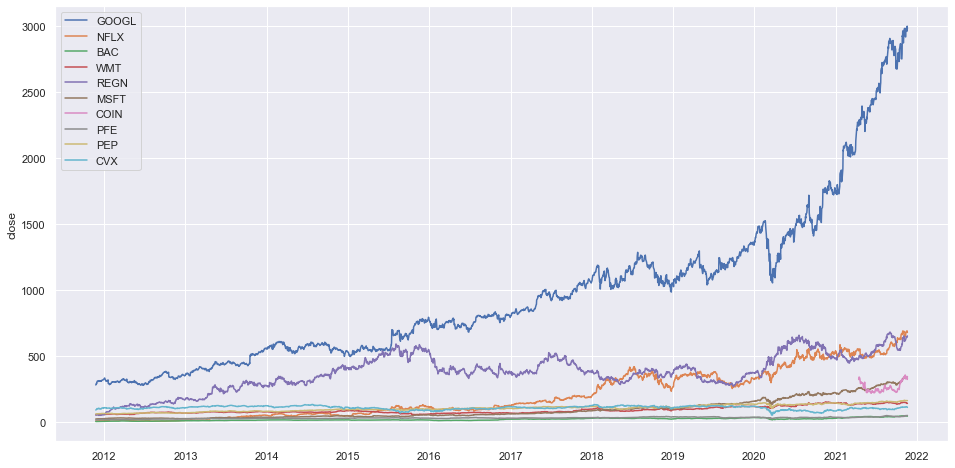

In [57]:
portfolio = {}

sns.set(rc = {'figure.figsize': (16,8)})

for ticker in tickers:
    tmp = si.get_data(ticker, start_date=start.strftime("%d/%m/%Y"), end_date=end.strftime("%d/%m/%Y"))
    tmp['daily_change'] = tmp['close'].pct_change()
    portfolio[ticker] = tmp['close']
    sns.lineplot(x=tmp.index, y='close', data=tmp, markers=True, label=ticker)

In [58]:
portfolio = pd.DataFrame.from_dict(portfolio)
portfolio.head()

,GOOGL,NFLX,BAC,WMT,REGN,MSFT,COIN,PFE,PEP,CVX
2011-11-25,281.781769,9.122857,5.17,56.889999,53.779999,24.299999,NaN,17.504744,62.490002,92.290001
2011-11-28,294.389374,9.992857,5.25,57.250000,57.360001,24.870001,NaN,18.111954,62.990002,95.769997
2011-11-29,291.756744,9.652857,5.08,58.169998,55.790001,24.840000,NaN,18.406073,63.660000,97.389999
2011-11-30,299.994995,9.218571,5.44,58.900002,59.419998,25.580000,NaN,19.041746,64.000000,102.820000
2011-12-01,307.192200,9.595714,5.53,58.610001,60.209999,25.280001,NaN,19.003796,64.089996,101.830002


In [59]:
returns_portfolio = portfolio.pct_change()
returns_portfolio.head()

,GOOGL,NFLX,BAC,WMT,REGN,MSFT,COIN,PFE,PEP,CVX
2011-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-28,0.044742,0.095365,0.015474,0.006328,0.066568,0.023457,NaN,0.034688,0.008001,0.037707
2011-11-29,-0.008943,-0.034024,-0.032381,0.016070,-0.027371,-0.001206,NaN,0.016239,0.010637,0.016916
2011-11-30,0.028237,-0.044990,0.070866,0.012549,0.065065,0.029791,NaN,0.034536,0.005341,0.055755
2011-12-01,0.023991,0.040911,0.016544,-0.004924,0.013295,-0.011728,NaN,-0.001993,0.001406,-0.009628


# Covariance matrix

In [60]:
covariance_matrix = returns_portfolio.cov()
covariance_matrix

,GOOGL,NFLX,BAC,WMT,REGN,MSFT,COIN,PFE,PEP,CVX
GOOGL,0.000252,0.000177,0.000131,0.000054,0.000120,0.000160,0.000048,0.000073,0.000071,0.000105
NFLX,0.000177,0.000909,0.000122,0.000064,0.000132,0.000166,0.000089,0.000055,0.000058,0.000074
BAC,0.000131,0.000122,0.000401,0.000061,0.000118,0.000138,0.000060,0.000098,0.000080,0.000204
WMT,0.000054,0.000064,0.000061,0.000149,0.000069,0.000070,0.000041,0.000052,0.000064,0.000047
REGN,0.000120,0.000132,0.000118,0.000069,0.000526,0.000114,0.000045,0.000103,0.000063,0.000071
MSFT,0.000160,0.000166,0.000138,0.000070,0.000114,0.000257,0.000070,0.000078,0.000086,0.000116
COIN,0.000048,0.000089,0.000060,0.000041,0.000045,0.000070,0.001306,-0.000049,0.000006,0.000016
PFE,0.000073,0.000055,0.000098,0.000052,0.000103,0.000078,-0.000049,0.000166,0.000063,0.000082
PEP,0.000071,0.000058,0.000080,0.000064,0.000063,0.000086,0.000006,0.000063,0.000122,0.000078
CVX,0.000105,0.000074,0.000204,0.000047,0.000071,0.000116,0.000016,0.000082,0.000078,0.000305


Text(0.5, 1.0, 'Portfolio Pearson correlation')

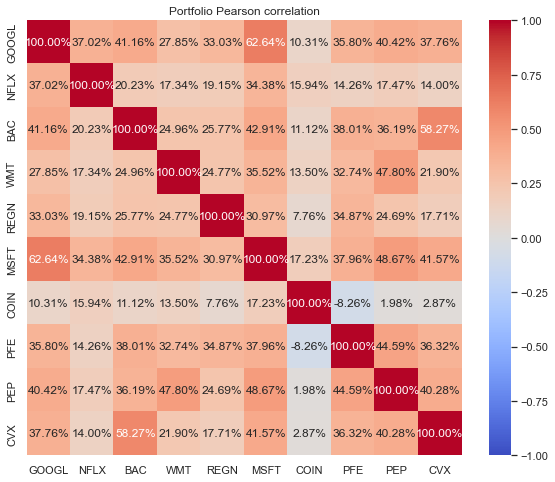

In [61]:
sns.set(rc = {'figure.figsize': (10, 8)})
sns.heatmap(
    returns_portfolio.corr(method='pearson'), 
    annot=True, 
    square=True, 
    fmt=".2%", 
    cmap=sns.color_palette("coolwarm", as_cmap=True),
    vmin=-1, vmax=1
).set_title('Portfolio Pearson correlation')

# Portfolio return and volatility

In [62]:
weight_portfolio = [0.05 for _ in range(len(tickers))]
portfolio_return = (returns_portfolio.mean()*252).dot(weight_portfolio)
portfolio_variance = np.transpose(weight_portfolio)@covariance_matrix@weight_portfolio*252
portfolio_volatility = np.sqrt(portfolio_variance)

print("Portfolio return is:", round(portfolio_return, 5))
print("Portfolio variance is:", round(portfolio_variance, 5))
print("Portfolio volatility is:", round(portfolio_volatility, 5))

Portfolio return is: 0.11431
Portfolio variance is: 0.00748
Portfolio volatility is: 0.08651


# Optimizing portfolio

In [63]:
pt_returns = []
pt_volatility = []
pt_weights = []

In [64]:
num_assets = len(portfolio.columns)
indivual_rets = returns_portfolio.mean()*252

#number of simulations
num_portfolios = 2000 #1000

#min and max weight of any stock in our portfolio
weights_range = [0.05, 0.2]

In [65]:
for port in range(num_portfolios):
    #Random generation of weights
    weights = weights_sampler(num_assets, 1, weights_range)
    pt_weights.append(weights)
    
    #Returns with these new weights
    returns = np.dot(weights, indivual_rets)
    pt_returns.append(returns)
    
    #portfolio variance
    variance = np.transpose(weights)@covariance_matrix@weights*252
    volatility = np.sqrt(variance)
    pt_volatility.append(volatility)

In [66]:
data = {'returns':pt_returns, 'volatility':pt_volatility}

for counter,symbol in enumerate(portfolio.columns.tolist()):
    data[symbol] = [w[counter] for w in pt_weights]
    
portfolios_V1 = pd.DataFrame(data)
portfolios_V1.head()

,returns,volatility,GOOGL,NFLX,BAC,WMT,REGN,MSFT,COIN,PFE,PEP,CVX
0,0.215979,0.177373,0.122730,0.060771,0.051288,0.100987,0.126630,0.082596,0.164965,0.121574,0.091200,0.077268
1,0.250039,0.182427,0.104449,0.123226,0.112204,0.061679,0.161710,0.077539,0.085764,0.137224,0.049998,0.086212
2,0.221225,0.181281,0.122994,0.088279,0.100009,0.129590,0.049993,0.114306,0.151406,0.066385,0.050000,0.127047
3,0.219903,0.171599,0.162512,0.081917,0.060160,0.098096,0.134295,0.073132,0.054433,0.077467,0.105118,0.152870
4,0.254559,0.182436,0.158932,0.163965,0.139610,0.088867,0.049999,0.052315,0.083593,0.129244,0.083060,0.050424


Text(0, 0.5, 'Expected Returns')

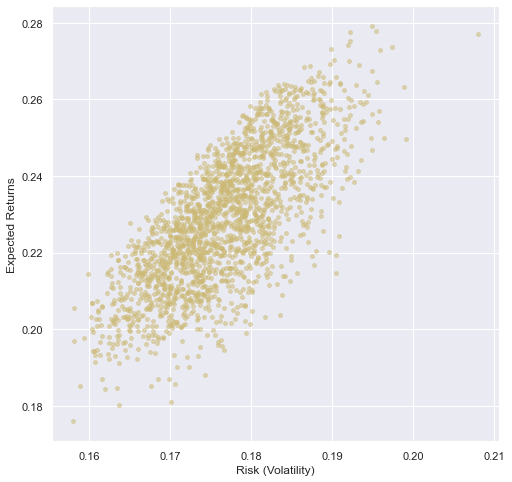

In [67]:
portfolios_V1.plot.scatter(x='volatility', y='returns', marker='o',color='y',
                           s=15, alpha=0.5,grid=True,figsize=[8,8])
plt.xlabel('Risk (Volatility)')
plt.ylabel('Expected Returns')

# Highest sharpe ratio

In [68]:
optimal_risky_pt = portfolios_V1.iloc[((portfolios_V1['returns'])/
                                       portfolios_V1['volatility']).idxmax()]

print("Weights of your stocks:\n", optimal_risky_pt)

Weights of your stocks:
 returns       0.277572
volatility    0.192165
GOOGL         0.148060
NFLX          0.155977
BAC           0.073074
WMT           0.052116
REGN          0.159250
MSFT          0.153533
COIN          0.072299
PFE           0.049998
PEP           0.074805
CVX           0.060895
Name: 1640, dtype: float64


Text(0, 0.5, 'Expected Returns')

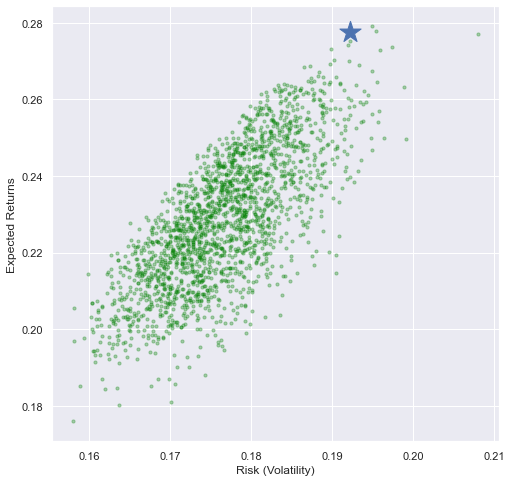

In [69]:
plt.subplots(figsize=(8,8))
plt.scatter(portfolios_V1['volatility'], portfolios_V1['returns'], marker='o',
            s=10, alpha=0.3,color='green')
plt.scatter(optimal_risky_pt[1], optimal_risky_pt[0], marker='*',
            s=500, color='b')
plt.xlabel('Risk (Volatility)')
plt.ylabel('Expected Returns')

In [73]:
opt_sharpe_ratio_rf = (optimal_risky_pt['returns']-risk_free_rate)/optimal_risky_pt['volatility']
print('Sharpe ratio in the optimized portfolio considering risk-free ratio:', round(opt_sharpe_ratio_rf, 5))
opt_sharpe_ratio_wrf = optimal_risky_pt['returns']/optimal_risky_pt['volatility']
print('Sharpe ratio in the optimized portfolio without risk-free ratio:', round(opt_sharpe_ratio_wrf, 5))

Sharpe ratio in the optimized portfolio considering risk-free ratio: 1.34318
Sharpe ratio in the optimized portfolio without risk-free ratio: 1.44445


# Calculating amounts and number of shares for stocks

In [71]:
your_amount = 70000

In [72]:
for v,k in dict(optimal_risky_pt).items():
    if v not in ['returns', 'volatility']:
        stock_amount = your_amount*k
        num_shares = int(stock_amount/dict(live_prices)[v])
        print(f"Invest {round(stock_amount,3)}$ ({num_shares} positions) into {v}")

Invest 10364.203$ (3 positions) into GOOGL
Invest 10918.409$ (16 positions) into NFLX
Invest 5115.171$ (109 positions) into BAC
Invest 3648.138$ (25 positions) into WMT
Invest 11147.473$ (16 positions) into REGN
Invest 10747.288$ (31 positions) into MSFT
Invest 5060.95$ (16 positions) into COIN
Invest 3499.87$ (68 positions) into PFE
Invest 5236.379$ (31 positions) into PEP
Invest 4262.63$ (37 positions) into CVX


## References:

- [Ivan Prodaiko's portfolio two stocks portfolio optimization](https://github.com/IvanProdaiko94/portfolio_analytics)

- [Multiple stock portfolio optimization](https://www.analyticsvidhya.com/blog/2021/04/portfolio-optimization-using-mpt-in-python/)

- [Weights generation logic](https://softwareengineering.stackexchange.com/questions/254301/algorithm-to-generate-n-random-numbers-between-a-and-b-which-sum-up-to-x)
